**STAGE 1**

In [ ]:
#Needed for EDA in Google colab
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
#Read Data and Store it in a dataframe
# Generate data paths with labels
#Use your own dataset path in Google drive
data_dir = '/content/gdrive/MyDrive/Capstone Project'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
#EDA Q1:How is the data distribution
df.head(5)

,filepaths,labels
0,/content/gdrive/MyDrive/Capstone Project/AGAR3...,AGAR300(IEEE DataPort)
1,/content/gdrive/MyDrive/Capstone Project/AGAR3...,AGAR300(IEEE DataPort)
2,/content/gdrive/MyDrive/Capstone Project/AGAR3...,AGAR300(IEEE DataPort)
3,/content/gdrive/MyDrive/Capstone Project/AGAR3...,AGAR300(IEEE DataPort)
4,/content/gdrive/MyDrive/Capstone Project/AGAR3...,AGAR300(IEEE DataPort)


In [ ]:
df.tail(5)

,filepaths,labels
1779,/content/gdrive/MyDrive/Capstone Project/0/OIA...,0
1780,/content/gdrive/MyDrive/Capstone Project/0/OIA...,0
1781,/content/gdrive/MyDrive/Capstone Project/0/OIA...,0
1782,/content/gdrive/MyDrive/Capstone Project/conve...,converted_keras (1) new
1783,/content/gdrive/MyDrive/Capstone Project/conve...,converted_keras (1) new


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1784 entries, 0 to 1783
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1784 non-null   object
 1   labels     1784 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


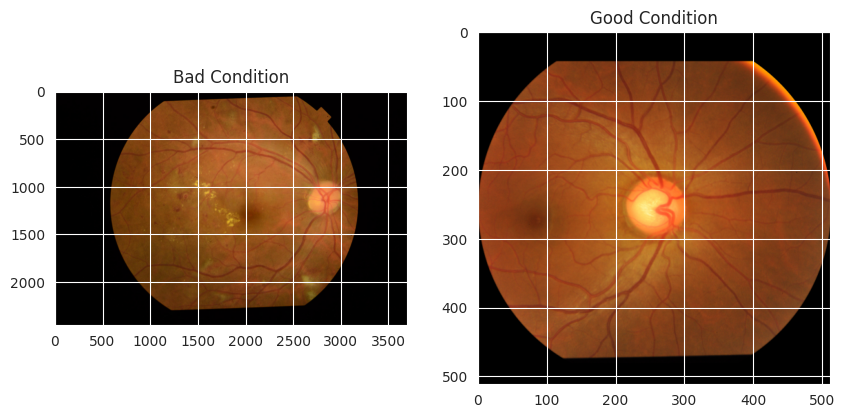

In [ ]:
#EDA Q2: How do images from different classes look like (Read and Display Images)

import cv2
import matplotlib.pyplot as plt

# Assuming you have two images, one representing a good condition and the other a bad condition
img_path_bad = '/content/gdrive/MyDrive/Capstone Project/AGAR300(IEEE DataPort)/2 (2) - Copy.JPG'
img_bad = cv2.imread(img_path_bad)

img_path_good = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'
img_good = cv2.imread(img_path_good)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_bad, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.title('Bad Condition')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_good, cv2.COLOR_BGR2RGB))
plt.title('Good Condition')

plt.show()


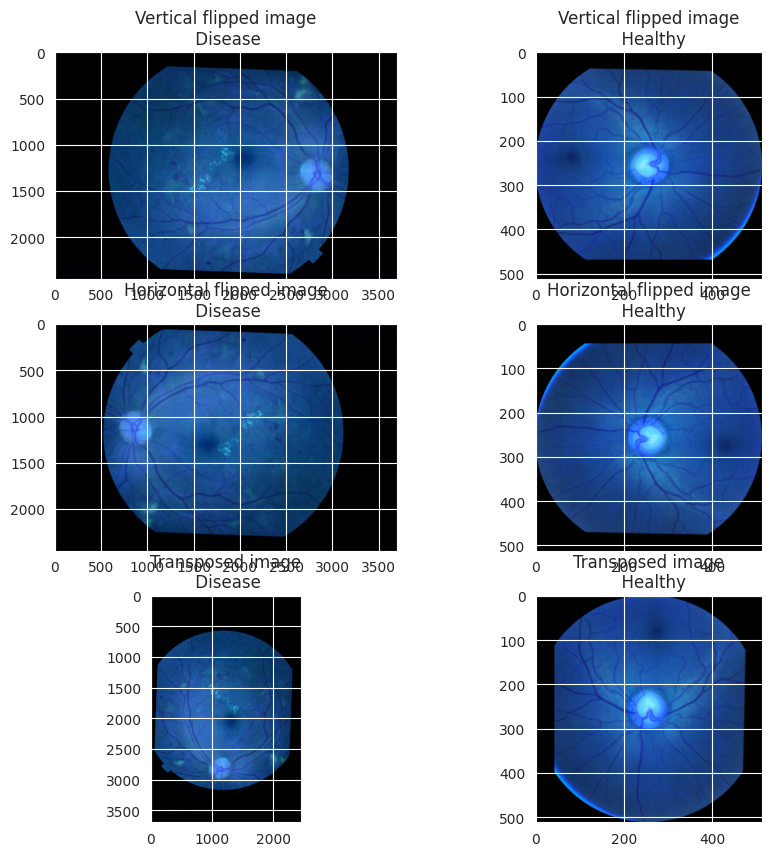

In [ ]:
# EDA Q3 - How does the images from different classes look like with geometrical transformations (vertical flipping, horizontal flipping, transposing)

import cv2
import matplotlib.pyplot as plt

# Load images
img_path_1 = '/content/gdrive/MyDrive/Capstone Project/AGAR300(IEEE DataPort)/2 (2) - Copy.JPG'
img_1 = cv2.imread(img_path_1)

img_path_2 = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'
img_2 = cv2.imread(img_path_2)

# Basic image manipulation (rotating/flipping/transpose)
flip_img_v1 = cv2.flip(img_1, 0)  # vertical flip
flip_img_v2 = cv2.flip(img_2, 0)  # vertical flip

# horizontal flip
flip_img_h1 = cv2.flip(img_1, 1)  # horizontal flip
flip_img_h2 = cv2.flip(img_2, 1)  # horizontal flip

# transpose
transp_img_1 = cv2.transpose(img_1)  # transpose
transp_img_2 = cv2.transpose(img_2)  # transpose

# Display the images
plt.figure(figsize=(10, 10))

plt.subplot(321)
plt.imshow(flip_img_v1)
plt.title('Vertical flipped image\n Disease')

plt.subplot(322)
plt.imshow(flip_img_v2)
plt.title('Vertical flipped image\n  Healthy')

plt.subplot(323)
plt.imshow(flip_img_h1)
plt.title('Horizontal flipped image\n Disease')

plt.subplot(324)
plt.imshow(flip_img_h2)
plt.title('Horizontal flipped image\n  Healthy')

plt.subplot(325)
plt.imshow(transp_img_1)
plt.title('Transposed image\n Disease')

plt.subplot(326)
plt.imshow(transp_img_2)
plt.title('Transposed image\n  Healthy')

plt.show()


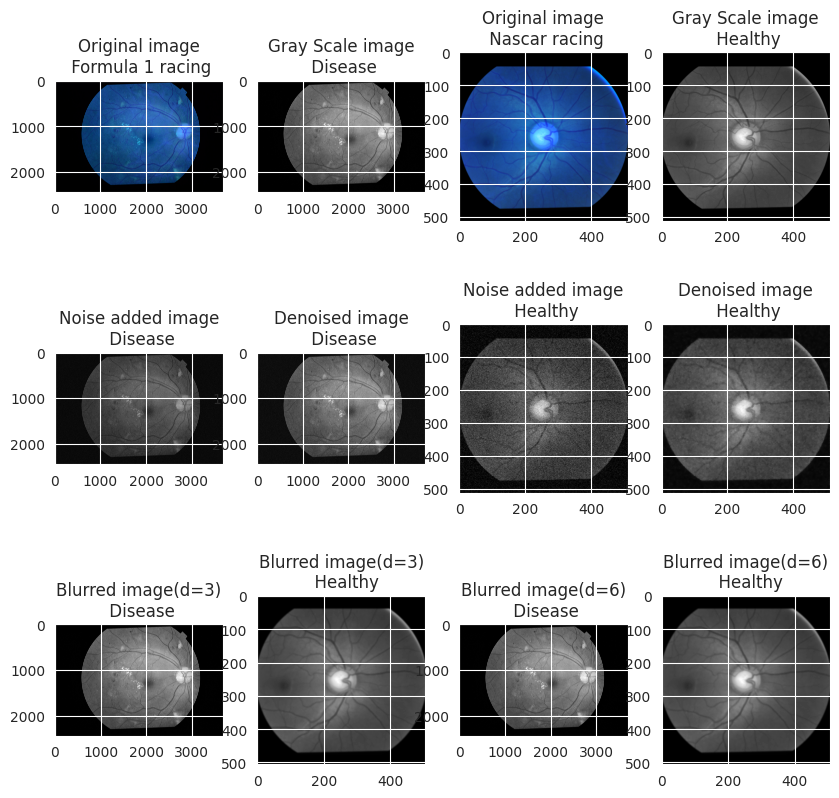

In [ ]:
################################################################
#Step 4 EDA: What is impact of noising and denoising operations on image
#quality (aka Colour and Texture Analysis)
#Conversion to Gray scale image needed for colour and texture analysis
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
import skimage.restoration
%matplotlib inline

# Image paths
img_path_1 = '/content/gdrive/MyDrive/Capstone Project/AGAR300(IEEE DataPort)/2 (2) - Copy.JPG'
img_path_2 = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'

# Load images
img_1 = cv2.imread(img_path_1)
img_2 = cv2.imread(img_path_2)

# Gray scale conversion
img_1_gray = skic.rgb2gray(img_1)
img_2_gray = skic.rgb2gray(img_2)

# Add Gaussian noise and denoise using denoise_tv_bregman approach for img_1 and img_2
img_1_n = sku.random_noise(img_1_gray)
img_1_d = skimage.restoration.denoise_tv_bregman(img_1_n, 5.)
img_2_n = sku.random_noise(img_2_gray)
img_2_d = skimage.restoration.denoise_tv_bregman(img_2_n, 5.)

# Noise reduction using Gaussian Blur
d = 3
img_1_blur3 = cv2.GaussianBlur(img_1_gray, (2*d+1, 2*d+1), -1)[d:-d, d:-d]
img_2_blur3 = cv2.GaussianBlur(img_2_gray, (2*d+1, 2*d+1), -1)[d:-d, d:-d]
img_1_blur6 = cv2.GaussianBlur(img_1_gray, (2*d+1, 2*d+1), -1)[d:-d, d:-d]
img_2_blur6 = cv2.GaussianBlur(img_2_gray, (2*d+1, 2*d+1), -1)[d:-d, d:-d]

# Visualizing Gray scale images visualization
plt.figure(figsize=(10, 10))

plt.subplot(3, 4, 1), plt.imshow(img_1), plt.title('Original image\n Formula 1 racing')
plt.subplot(3, 4, 2), plt.imshow(img_1_gray, cmap='gray'), plt.title('Gray Scale image\n Disease')
plt.subplot(3, 4, 3), plt.imshow(img_2), plt.title('Original image\n Nascar racing')
plt.subplot(3, 4, 4), plt.imshow(img_2_gray, cmap='gray'), plt.title('Gray Scale image\n Healthy')

# Visualizing Noising-Denoising images
plt.subplot(3, 4, 5), plt.imshow(img_1_n, cmap='gray'), plt.title('Noise added image\n Disease')
plt.subplot(3, 4, 6), plt.imshow(img_1_d, cmap='gray'), plt.title('Denoised image\n Disease')
plt.subplot(3, 4, 7), plt.imshow(img_2_n, cmap='gray'), plt.title('Noise added image\n Healthy')
plt.subplot(3, 4, 8), plt.imshow(img_2_d, cmap='gray'), plt.title('Denoised image\n Healthy')

# Visualizing Noise Reduction with Gaussian Blurring
plt.subplot(3, 4, 9), plt.imshow(img_1_blur3, cmap='gray'), plt.title('Blurred image(d=3)\n Disease')
plt.subplot(3, 4, 10), plt.imshow(img_2_blur3, cmap='gray'), plt.title('Blurred image(d=3)\n  Healthy')
plt.subplot(3, 4, 11), plt.imshow(img_1_blur6, cmap='gray'), plt.title('Blurred image(d=6)\n Disease')
plt.subplot(3, 4, 12), plt.imshow(img_2_blur6, cmap='gray'), plt.title('Blurred image(d=6)\n  Healthy')

plt.show()
################################################################

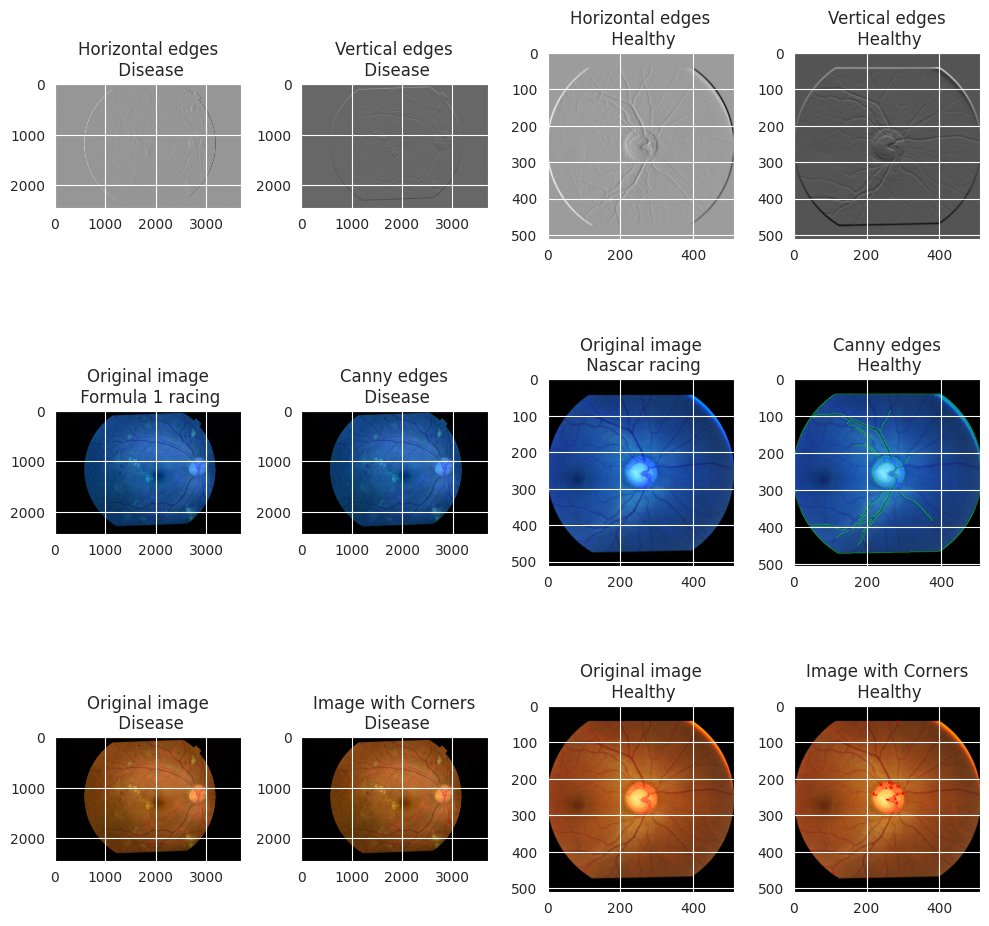

In [ ]:
################################################################
#Step 6 EDA- How discriminative are the salient features such as edges and
#corners for images corresponding to each class
#Conversion to Gray scale image needed for extracting edges and corners
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img_path_1 = '/content/gdrive/MyDrive/Capstone Project/AGAR300(IEEE DataPort)/2 (2) - Copy.JPG'
img_path_2 = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'

# Read images
img_1 = cv2.imread(img_path_1)
img_2 = cv2.imread(img_path_2)

# Sobel edge detector
sobel_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
sobel_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
sobelx_img_1 = cv2.Sobel(sobel_img_1, cv2.CV_64F, 1, 0, ksize=9)
sobely_img_1 = cv2.Sobel(sobel_img_1, cv2.CV_64F, 0, 1, ksize=9)
sobelx_img_2 = cv2.Sobel(sobel_img_2, cv2.CV_64F, 1, 0, ksize=9)
sobely_img_2 = cv2.Sobel(sobel_img_2, cv2.CV_64F, 0, 1, ksize=9)

# Canny edge detector
th1 = 30
th2 = 60
d = 3
edgeresult_1 = img_1.copy()
edgeresult_1 = cv2.GaussianBlur(edgeresult_1, (2*d+1, 2*d+1), -1)[d:-d, d:-d]
gray_1 = cv2.cvtColor(edgeresult_1, cv2.COLOR_BGR2GRAY)
edge_1 = cv2.Canny(gray_1, th1, th2)
edgeresult_1[edge_1 != 0] = (0, 255, 0)

edgeresult_2 = img_2.copy()
edgeresult_2 = cv2.GaussianBlur(edgeresult_2, (2*d+1, 2*d+1), -1)[d:-d, d:-d]
gray_2 = cv2.cvtColor(edgeresult_2, cv2.COLOR_BGR2GRAY)
edge_2 = cv2.Canny(gray_2, th1, th2)
edgeresult_2[edge_2 != 0] = (0, 255, 0)

# Corner detector
harris_1 = img_1.copy()
gray = cv2.cvtColor(harris_1, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
blocksize = 4
kernel_size = 3
dst = cv2.cornerHarris(gray, blocksize, kernel_size, 0.05)
dst = cv2.dilate(dst, None)
harris_1[dst > 0.01*dst.max()] = [0, 0, 255]

harris_2 = img_2.copy()
gray = cv2.cvtColor(harris_2, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, blocksize, kernel_size, 0.05)
dst = cv2.dilate(dst, None)
harris_2[dst > 0.01*dst.max()] = [0, 0, 255]

# Visualizing Edges and Corners
plt.figure(figsize=(10, 10))

# Visualizing Sobel Edges
plt.subplot(341), plt.imshow(sobelx_img_1, cmap='gray'), plt.title('Horizontal edges\n Disease')
plt.subplot(342), plt.imshow(sobely_img_1, cmap='gray'), plt.title('Vertical edges\n Disease')
plt.subplot(343), plt.imshow(sobelx_img_2, cmap='gray'), plt.title('Horizontal edges\n Healthy')
plt.subplot(344), plt.imshow(sobely_img_2, cmap='gray'), plt.title('Vertical edges\n Healthy')

# Visualizing Canny Edges
plt.subplot(345), plt.imshow(img_1), plt.title('Original image\n Formula 1 racing')
plt.subplot(346), plt.imshow(edgeresult_1, cmap='gray'), plt.title('Canny edges\n Disease')
plt.subplot(347), plt.imshow(img_2), plt.title('Original image\n Nascar racing')
plt.subplot(348), plt.imshow(edgeresult_2, cmap='gray'), plt.title('Canny edges\n Healthy')

# Visualizing Corners
plt.subplot(349), plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)), plt.title('Original image\n Disease')
plt.subplot(3, 4, 10), plt.imshow(cv2.cvtColor(harris_1, cv2.COLOR_BGR2RGB)), plt.title('Image with Corners\n Disease')
plt.subplot(3, 4, 11), plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)), plt.title('Original image\n Healthy')
plt.subplot(3, 4, 12), plt.imshow(cv2.cvtColor(harris_2, cv2.COLOR_BGR2RGB)), plt.title('Image with Corners\n Healthy')

plt.tight_layout()
plt.show()
################################################################

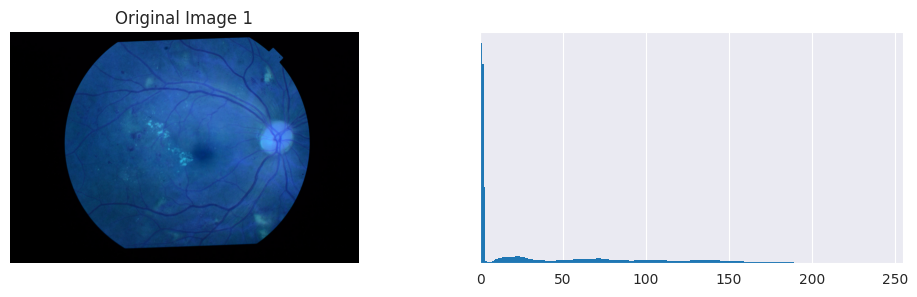

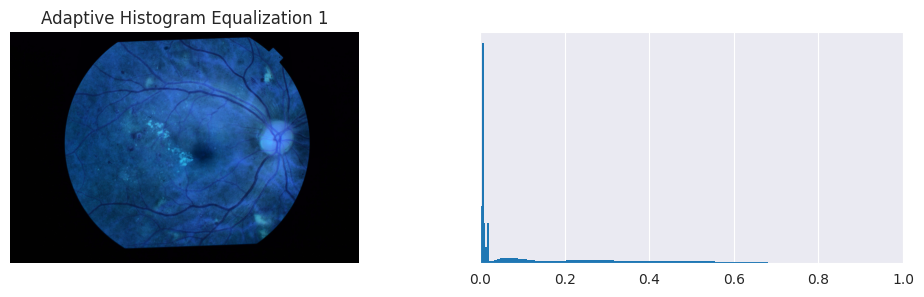

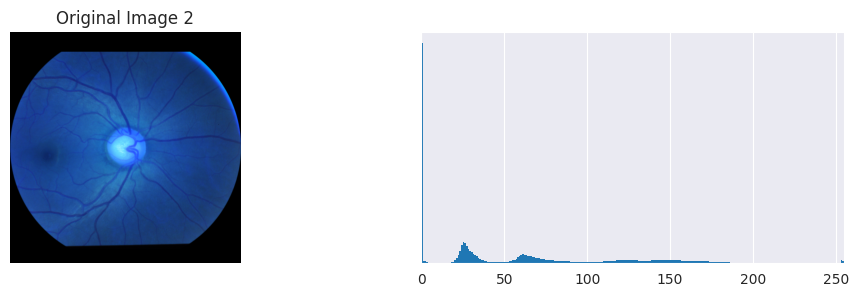

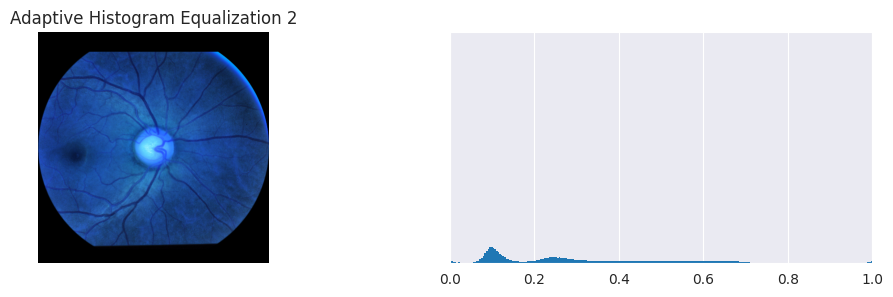

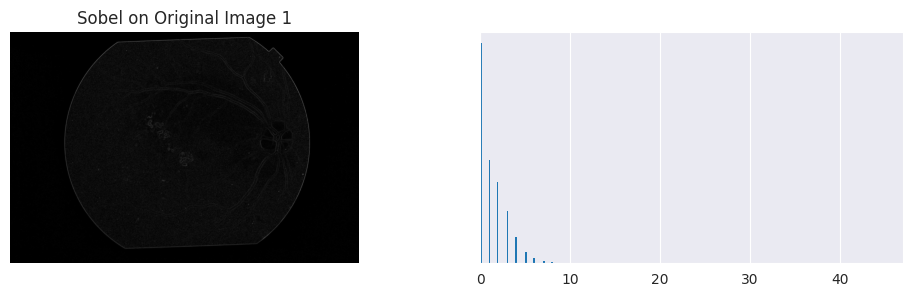

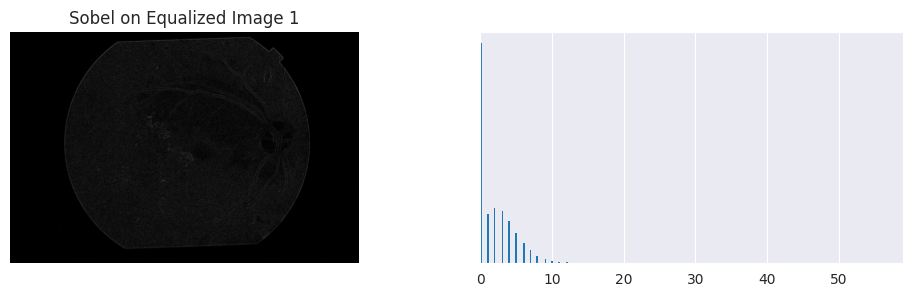

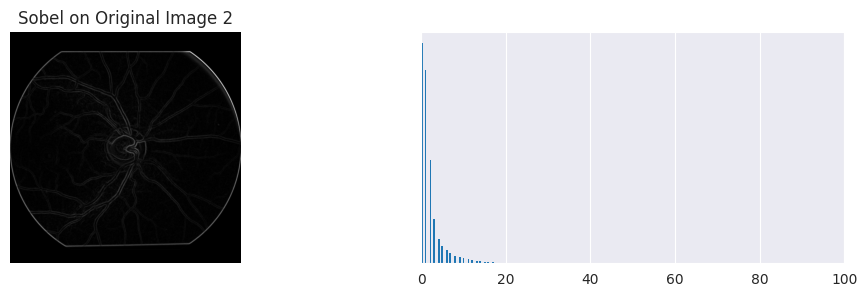

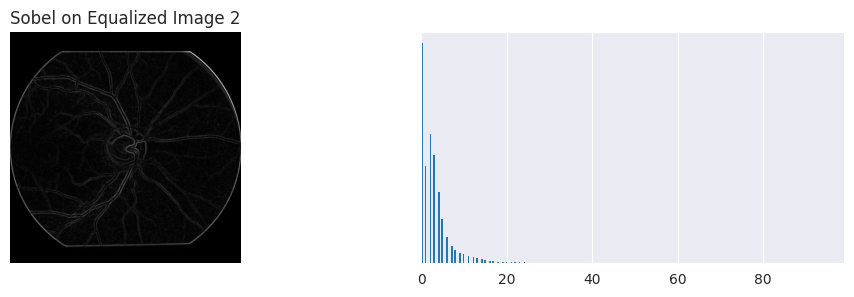

In [ ]:
#Step 6 EDA: How discriminative are the images from different categories in terms of illumination and lighting artefacts
# i.e. what is the impact of camera effects/exposure of an image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.util as sku
import skimage.exposure as skie
from skimage import img_as_ubyte  # Add this import to handle image types
%matplotlib inline

img_path_1 = '/content/gdrive/MyDrive/Capstone Project/AGAR300(IEEE DataPort)/2 (2) - Copy.JPG'
img_path_2 = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'

img_1 = cv2.imread(img_path_1)
img_2 = cv2.imread(img_path_2)

def show(img, title=''):
    # Display the image and histogram.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()
    ax1.set_title(title)

    # Display the histogram.
    ax2.hist(img.ravel(), lw=0, bins=256)
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])

    plt.show()

# Show original images and their adaptive histogram equalization
show(img_1, 'Original Image 1')
show(skie.equalize_adapthist(img_1), 'Adaptive Histogram Equalization 1')
show(img_2, 'Original Image 2')
show(skie.equalize_adapthist(img_2), 'Adaptive Histogram Equalization 2')

# Class 1 image
img_gray_1 = skic.rgb2gray(img_1)
sobimg_nheq_1 = skif.sobel(img_gray_1)
show(img_as_ubyte(sobimg_nheq_1), 'Sobel on Original Image 1')

img_eq_1 = skie.equalize_adapthist(img_1)
img_gray_eq_1 = skic.rgb2gray(img_eq_1)
sobimg_heq_1 = skif.sobel(img_gray_eq_1)
show(img_as_ubyte(sobimg_heq_1), 'Sobel on Equalized Image 1')

# Class 2 image
img_gray_2 = skic.rgb2gray(img_2)
sobimg_nheq_2 = skif.sobel(img_gray_2)
show(img_as_ubyte(sobimg_nheq_2), 'Sobel on Original Image 2')

img_eq_2 = skie.equalize_adapthist(img_2)
img_gray_eq_2 = skic.rgb2gray(img_eq_2)
sobimg_heq_2 = skif.sobel(img_gray_eq_2)
show(img_as_ubyte(sobimg_heq_2), 'Sobel on Equalized Image 2')


0 1


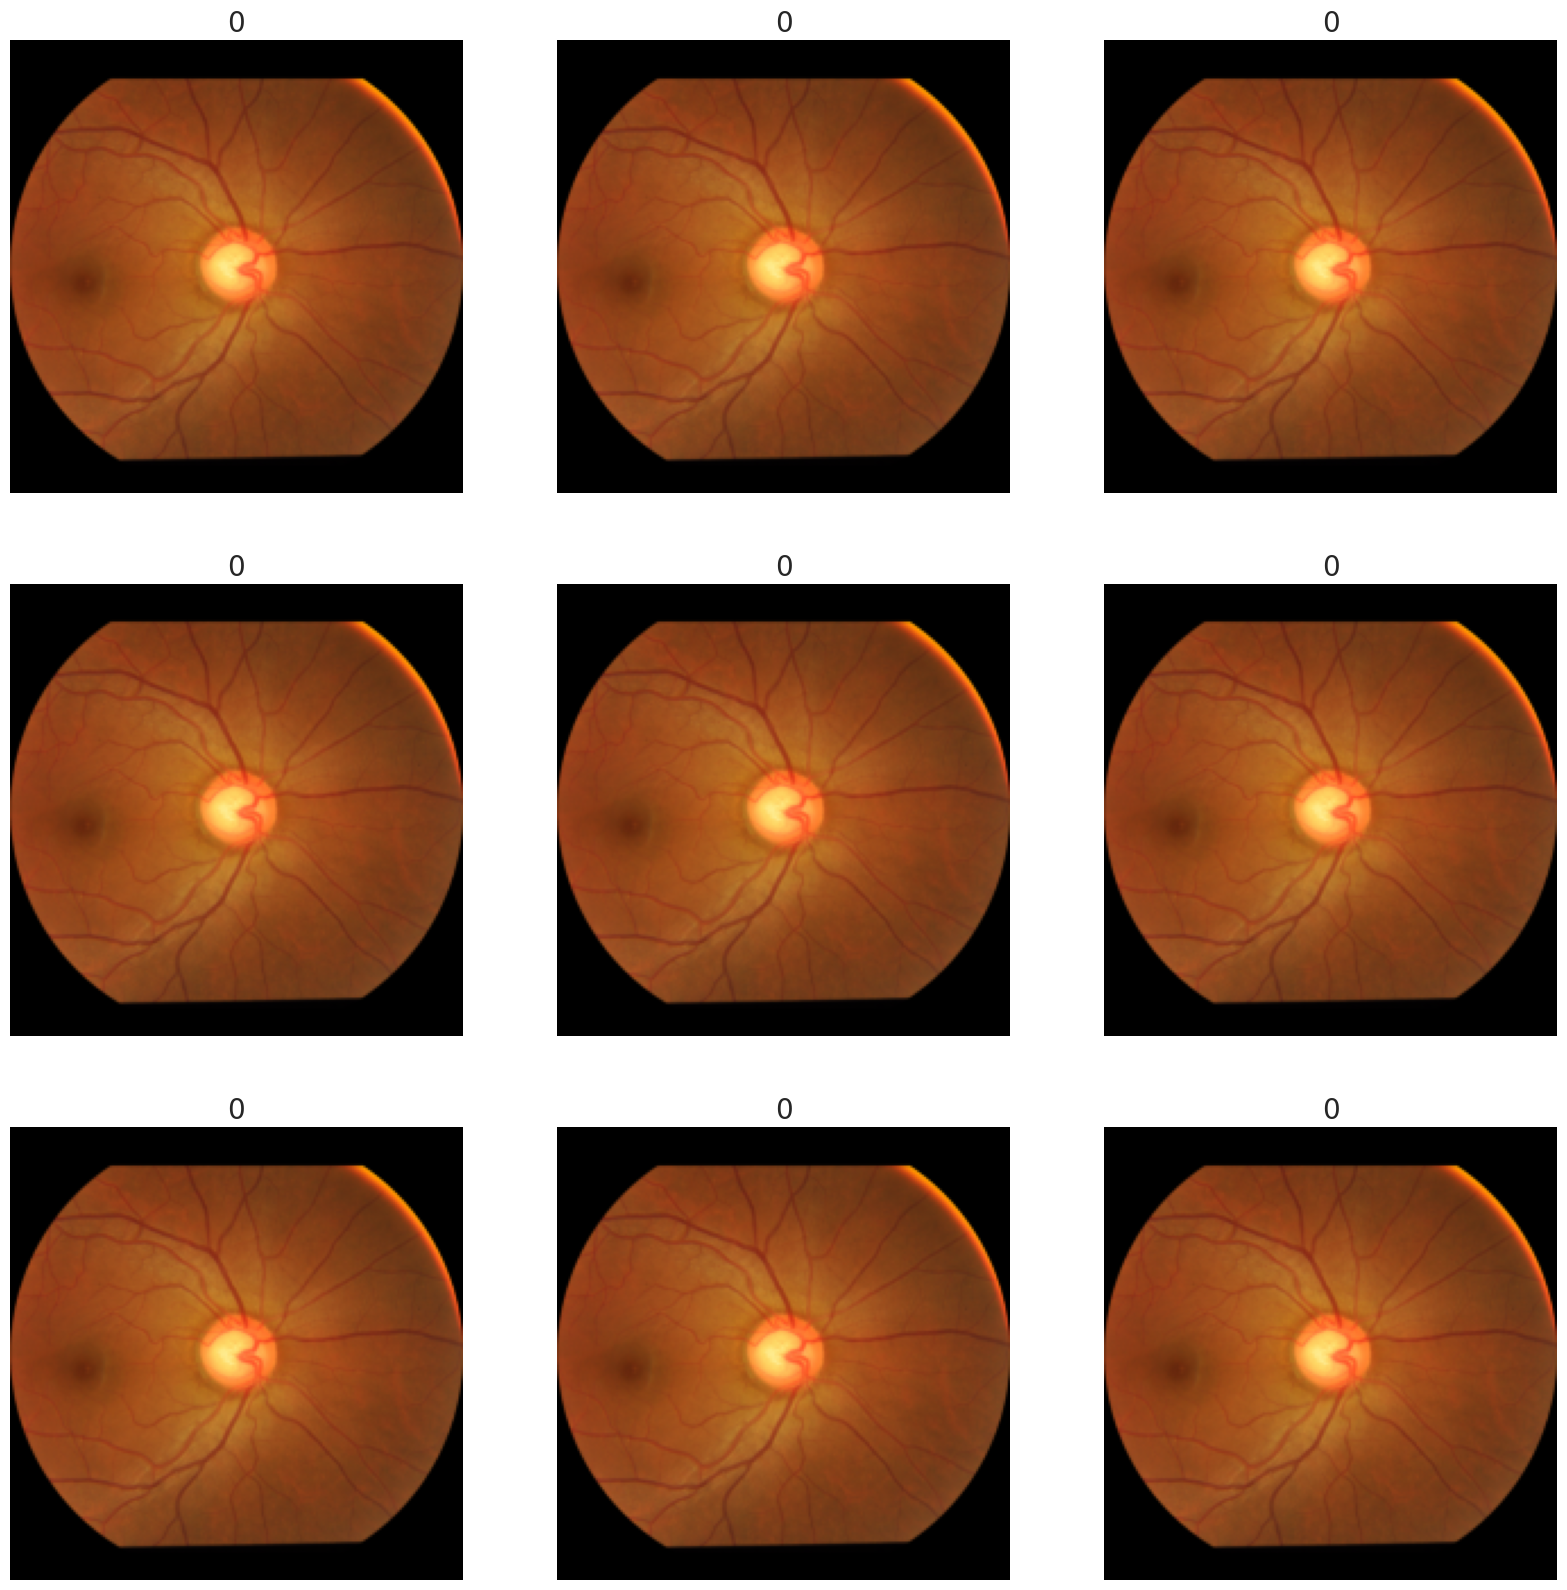

In [ ]:
#Step 7 EDA : How many images are there in each class and how discriminative are the images from all classes?
#Requires GPU to be turned on (Go to Run time from menu, and choose change run time type and then choose GPU option )
%matplotlib inline
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from glob import glob
from matplotlib import pyplot as plt
import glob

images = []
X, y = [], []
ppc = 16
sz = 200
img_path = '/content/gdrive/MyDrive/Capstone Project/0/BEH-180.png'

image_files = glob.glob(img_path)
label = img_path.split('/')[-2]  # Extracting label from the path

print(label, len(image_files))

for image_file in image_files:
    image = resize(imread(image_file), (sz, sz))
    images.append(image)
    X.append(image)
    y.append(label)

n = 3
indices = np.random.choice(len(images), n * n)

plt.figure(figsize=(20, 20))
plt.gray()
i = 1
for index in indices:
    plt.subplot(n, n, i)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title(y[index], size=20)
    i += 1

plt.show()
